# 0. Computer vision libraries in PyTorch

* 'Torch vision' - base domain for PyTorch Computer vision at: 'https://pytorch.org/vision/stable/index.html'
  * torchvision.datasets  get datasets and data loading funcs for computer vision here
  * torchvision.models - get pretrained computer vision models from here
  * torchvision.transforms - functions for manipulating your vision data (images) to be suitable for use with an ML model
  * torch.utils.data.Dataset - Base dataset class for PyTorch
  * torch.utils.data.DataLoader - Creates a Python iterable over a dataset


In [1]:
# import necessary libraries

# PyTorch based
import torch as pt
from torch import nn
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # converts pil imag3e or np array to FloatTensor of shape (C x H x W)
import torchmetrics as tm

# Matplotlib for visualization
import matplotlib.pyplot as plt

print(pt.__version__)
print(tv.__version__)

C:\Users\22gusgam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


2.0.1+cu118
0.15.2+cu118


### 1. Getting a dataset

The dataset we will be using is FashionMNIST from torchvision.datasets, (a dataset of gray scale images of clothing): https://pytorch.org/vision/main/datasets.html

In [2]:
# Setup training data
import os
print(os.getcwd())
train_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data", # where should the file be placed
    train=True, # do we want to get the training dataset
    download=True, # do we want to download the dataset
    transform=ToTensor(), # how do we want to transform the data, 
    target_transform=None # how do we want to transform the labels/targets
    )

test_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
    )

c:\Users\22gusgam\Desktop\programmering\PyTorch\03


In [3]:
print(len(train_data),len(test_data))

60000 10000


### Visualizing our dataset

#### As numbers

In [4]:
train_data.data.shape # batch size of 60000

torch.Size([60000, 28, 28])

In [5]:
# See the first training example
image, label = train_data[0]
class_names = train_data.classes
class_names[label]

'Ankle boot'

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
# Check the shape of our image
print(f"image shape{image.shape} -> [Color channels, height, width]")
print(f"image_label: {class_names[label]}")

image shapetorch.Size([1, 28, 28]) -> [Color channels, height, width]
image_label: Ankle boot


#### As pictures

image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot, 9')

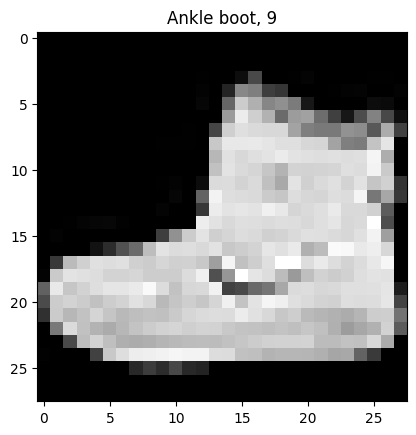

In [8]:
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap=plt.cm.gray)
plt.title(f"{class_names[label]}, {label}")

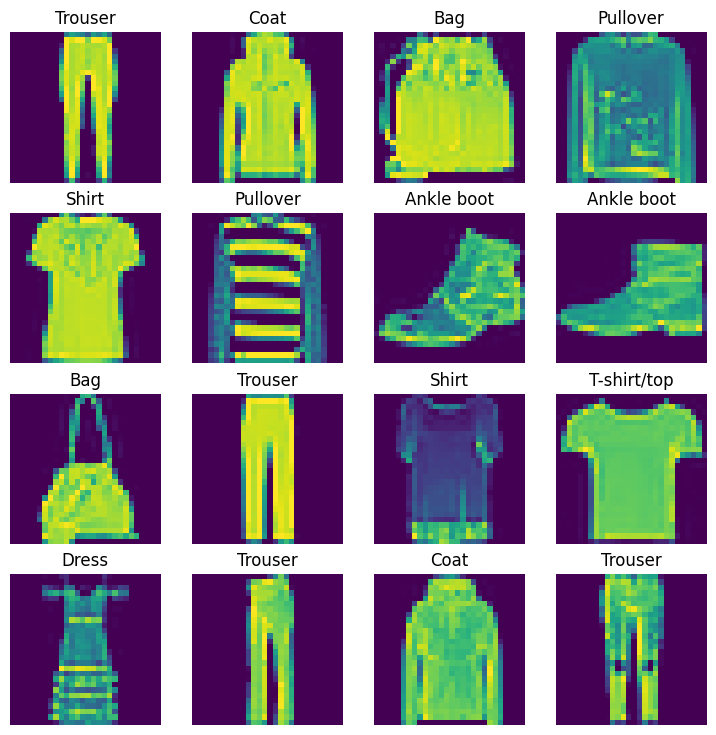

In [9]:
# Plot more images

#pt.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = pt.randint(0, len(train_data), size=[1]).item()
    #print(random_idx,i)
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()) #, cmap="gray"
    plt.title(class_names[label])
    plt.axis(False)

Is non linearity necessary or not?

### Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets

DataLoaders turn our dataset into a Python iterable
more specifically, we want to turn our data into batches i.e mini-batches

Why do this?
1. It is more computationally efficient, as your computer may not be able to store 60000 images at the same time, therefore we brake it down to ex 32 images at a time (batch size)
2. it gives our nn more chances to update its gradient per epoch (update for each 32 images)

In [10]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into a generator like BataLoader that generates batches
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True) # shuffle = True gör att alla värden i arrayen blandas
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)





In [11]:
# Let's check out the dataloader
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000028425104690>, <torch.utils.data.dataloader.DataLoader object at 0x000002842509AD10>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [12]:
# Check out what's inside the training dataloader
train_features_batch, training_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, training_labels_batch.shape
# [32 batches, 1 color channel, 28 by, 28 pixels], 32 labels associated with the train_data

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

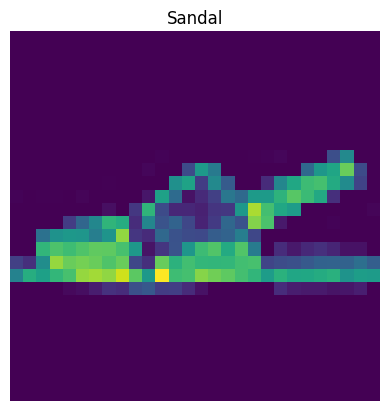

In [13]:
# Show a sample
pt.manual_seed(42)
random_idx = pt.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], training_labels_batch[random_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label.item()])
plt.axis(False)


## Model 0 specific

### Creating a model

Build a basline ModuleNotFoundError

When starting to build a series of ml modelling experiments it's good to start with a baseline model

A baseline model is a simple model, which you will improve upon with experiments

I.e start simple and add complexity

In [15]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

output = flatten_model(x) # perform a forward pass on the flatten model
# annan metod:
# pt.reshape(x, [1,-1]).shape

# Print results
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [16]:
pt.manual_seed(42)
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # kör genom flatten layer likt i exemplet ovan
            nn.Linear(input_shape, hidden_units),
            #nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
        )
    def forward(self,x):
        return self.layer_stack(x)


In [17]:
device = "cuda" if pt.cuda.is_available() else "cpu"
pt.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # i.e 28*28
    hidden_units=10,
    output_shape=len(class_names) # one for every class
).to(device)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = pt.rand([1,1,28,28])
#print(dummy_x)
print(model_0(dummy_x))

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)


### Setup loss, optimizer and evaluation metrics

* Loss function - Since we are working with multiclass data, our loss function will be nn.CrossEntropyLoss()

* Optimizer - Our optimizer will be SGD (stochastic gradient descent)
* Evaluation metric - since we are working on a classification problem, lets use accuracy oas our evaluation metric

In [1]:
from importLib import import_from_github
import_from_github("https://raw.githubusercontent.com/GGisMee/PyTorch/main/ml_toolkit/helper_functions.py")
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = pt.optim.SGD(params=model_0.parameters(), lr=0.1)





c:\Users\22gusgam\Desktop\k\PyTorch\03/helper_functions.py already exists


NameError: name 'nn' is not defined

#### Create a function to time the experiments

Machine learning is very experimental.

Two things we ofter track are:
1. The models performance (loss and accuracy)
2. How fast it runs with this function

In [20]:
from timeit import default_timer as timer
def print_train_time(start:float, device:pt.device = None):
     """print the difference between start and end time"""
     
     total_time = timer()-start
     print(f"Train time on {device}: {total_time:.3f} seconds")
     return total_time

In [21]:
start_time = timer()
print_train_time(start_time, device="cpu")

Train time on cpu: 0.000 seconds


5.1800161600112915e-05

### Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss per batch
4. print results, time for the loo

flow:

- for epoch:
    - for training_batch:
        - ...
    - for testing_batch:
        - ...
    - print(results, time)



In [22]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: c:\Users\22gusgam\Desktop\programmering\PyTorch\03/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [23]:
# Import tqdm for progress bar
from tqdm.auto import tqdm # auto gör att den automatiskt väljer hur progress baren ska se ut ex för normal .py eller .ipynb

# Set the seed and start the timer
pt.manual_seed(42)
train_time = timer()

# Set the number of epochs (small for faster training time and testing)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}") 
    ### Training
    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_logits = model_0(X)
        loss = loss_fn(y_logits, y)

        train_loss += loss # accumulate train loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Print what is happening
        if batch % int(len(train_dataloader.dataset)/(4*len(X))) == 0 and batch != 0:
            # batch (numret av batch) * bilder i batch (32) / antalet bilder i hela datasetet 
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples") 
    
    # Devide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with pt.inference_mode():
        for X_test,y_test in test_dataloader:
            test_logits = model_0(X_test)
            test_loss += loss_fn(test_logits, y_test)
            test_acc += accuracy_fn(y_test, test_logits.argmax(dim=1))
        # Calculate the test loss (avg per batch) and test accuracy
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    # Print out whats happening
    print(f"""
          Train loss: {train_loss:.4f}, 
          Test loss: {test_loss:.4f},
          Test acc: {test_acc:.4f}
          \n""")
# Calculate train time
print_train_time(train_time, device=str(next(model_0.parameters()).device))
pass


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 14976/60000 samples
Looked at 29952/60000 samples
Looked at 44928/60000 samples
Looked at 59904/60000 samples

          Train loss: 0.5904, 
          Test loss: 0.5095,
          Test acc: 82.0387
          

Epoch: 1
Looked at 14976/60000 samples
Looked at 29952/60000 samples
Looked at 44928/60000 samples
Looked at 59904/60000 samples

          Train loss: 0.4763, 
          Test loss: 0.4799,
          Test acc: 83.1969
          

Epoch: 2
Looked at 14976/60000 samples
Looked at 29952/60000 samples
Looked at 44928/60000 samples
Looked at 59904/60000 samples

          Train loss: 0.4550, 
          Test loss: 0.4766,
          Test acc: 83.4265
          

Train time on cpu: 47.952 seconds


### Make predictions and get Model 0:s results

In [39]:
pt.manual_seed(42)

def eval_model(model:pt.nn.Module, 
               data_loader: pt.utils.data.DataLoader, 
               loss_fn: pt.nn.Module,
               accuracy_fn,
               device:str):
    """Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0,0
    model.eval()
    with pt.inference_mode():
        for X,y in data_loader:
            X.to(device), y.to(device)
            y_pred_logits = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred_logits, y)
            acc += accuracy_fn(y, y_pred_logits.argmax(dim=1))
        
        # Get the average loss and acc per batch, by deviding by total
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name":model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc
            }        

In [25]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device="cpu")
print(model_0_results)

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4766390025615692, 'model_acc': 83.42651757188499}


## Model 1

In [14]:
import torch as pt
from torch import nn
device = "cuda" if pt.cuda.is_available() else "cpu"

In [15]:
#### Make a hopefully improved model using non-linearity
pt.manual_seed(42)
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # kör genom flatten layer likt i exemplet ovan
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU(),
        )
    def forward(self,x: pt.Tensor) -> pt.Tensor:
        return self.layer_stack(x)

In [16]:
# Create an instance of model_1
pt.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names) # send to the gpu is available
                              ).to(device)

In [17]:
next(model_1.parameters()).device

device(type='cpu')

In [18]:
### Setup loss, optimizer and evaluation metrics
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = pt.optim.SGD(params=model_1.parameters(), lr=0.1)


### Setup a train and a test loop function 

In [34]:
def train_step(model: pt.nn.Module,
               dataloader:pt.utils.data.DataLoader,
               optimizer:pt.optim.Optimizer,
               loss_fn:pt.nn.Module,
               accuracy_fn,
               device:pt.device = device,
               show:bool = False) -> tuple:
    """Performs a training step with model trying to learn on data_loader
    
    args:
        model: the model which will be trained on
        dataloader: A generator like loader for the data
        optimizer: Optimizer which optimizes the code through gradient descend
        loss_fn: function which calculates how far from the right answer each of the predictions were
        accuracy_fn: function which calculates how meny predictions were right
        device: chosen device for the neural network to run on (cpu/gpu/tpu)
        show: if true display the loss and acc in console 
    
    returns:
        if show: (loss, accuracy) else None"""
    train_loss, train_acc = 0,0
    ### Training
    model.train()
    for X,y in dataloader:
        # Put data to the right device
        X,y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_logits, y)

        # Accumulate values
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y, y_logits.argmax(dim=1)) # accumulate accuracy, goes from logits -> prediction labels with argmax(dim=1)

        # optimizer zero grad, Loss backward,   Optimizer step
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    
    # Devide total train loss and acc by length of train dataloader
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    if show:
        print(f"train loss: {train_loss}, train accuracy: {train_acc}")
    #return (train_loss, train_acc) 
    

In [35]:
def test_step(model: pt.nn.Module,
               dataloader:pt.utils.data.DataLoader,
               loss_fn:pt.nn.Module,
               accuracy_fn,
               device:pt.device = device,
               show:bool = False) -> tuple:
    """Performs a testing loop step on model going over data_loader.
    
    args:
        model: the model which will be trained on
        dataloader: A generator like loader for the data
        loss_fn: function which calculates how far from the right answer each of the predictions were
        accuracy_fn: function which calculates how meny predictions were right
        device: chosen device for the neural network to run on (cpu/gpu/tpu)
        show: if true display the loss and acc in console 
    
    returns:
        if show: (loss, accuracy) else None"""
    
    # Create loss and acc variables
    test_loss, test_acc = 0, 0

    # Puts the model on evaluation mode
    model.eval()

    # Turn on inference mode (Predictions mode) to look at the data  
    with pt.inference_mode():
        for X,y in dataloader:
            # Device agnostic
            X.to(device), y.to(device)

            # Forward pass
            test_logits = model(X)

            # Acumulate the loss and accuracy
            test_loss += loss_fn(test_logits, y)
            test_acc += accuracy_fn(y, test_logits.argmax(dim=1))

        # Calculate the loss (avg per batch) and accuracy
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    if show:
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}") 
    #return test_loss, test_acc


### Setup train and test func runner + evaluate

In [36]:
epoch = 3
start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_step(model_1, train_dataloader, optimizer, loss_fn,accuracy_fn, device,True)
    test_step(model_1, train_dataloader, loss_fn,accuracy_fn, device,True)
total_time = print_train_time(start, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
train loss: 0.8423582315444946, train accuracy: 70.13833333333334
Test loss: 0.6950, Test acc: 74.6533
Epoch: 1
train loss: 0.6774541735649109, train accuracy: 75.30833333333334
Test loss: 0.6339, Test acc: 76.5583
Epoch: 2
train loss: 0.6505247354507446, train accuracy: 76.28
Test loss: 0.6475, Test acc: 76.3867
Train time on cpu: 78.855 seconds


In [ ]:
print(model_0_results)
print()

**Note** Sometimes the cpu is faster then the gpu, why?
> 1. It could be that the overhead for copying data/model to and from gpu is higher then compute benefits, ex. X.to("cuda")
> 2. (Rare) the cpu is simply better then the gpu in compute capabilities
>
> For more look on: https://horace.io/brrr_intro.html

In [25]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn, device=device)
print("As you can see after 3 epochs each the linear model is better")
print(model_1_results, model_0_results)

NameError: name 'eval_model' is not defined

In [63]:
for picture_chosen in range(32): 
    print(model_1(next(iter(test_dataloader))[0][picture_chosen]).argmax(dim=1).item(), next(iter(test_dataloader))[1][picture_chosen].item())

9 9
2 2
1 1
1 1
6 6
1 1
4 4
6 6
5 5
7 7
4 4
5 5
5 7
0 3
4 4
1 1
2 2
4 4
8 8
0 0
0 2
7 5
7 7
7 9
1 1
2 4
6 6
0 0
9 9
4 3
8 8
8 8
